In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import torch
import torch.nn as nn
from assets.LSTM import LSTM
from assets.Transformer import Transformer
import numpy as np
import torch.optim as optim
import torch.utils.data as data
from sklearn.preprocessing import MinMaxScaler

In [2]:
def create_dataset(dataset, lookback):
    """Transform a time series into a prediction dataset
    
    Args:
        dataset: A numpy array of time series, first dimension is the time steps
        lookback: Size of window for prediction
    """
    X, y = [], []
    for i in range(len(dataset)-lookback):
        feature = dataset[i:i+lookback]
        target = dataset[i+1:i+lookback+1]
        X.append(feature)
        y.append(target)
    return torch.tensor(X,dtype=torch.float32), torch.tensor(y,dtype=torch.float32)

In [3]:
raw_data = pd.read_csv("./data/data.csv")

In [4]:
df = raw_data[raw_data['unique_id']=='AAAHol']

In [5]:
scaler = MinMaxScaler()
df['visits_scaled'] = scaler.fit_transform(df[['visits']])

/var/folders/n0/h0y2mn7n655844sg5fmgh4gwm203r_/T/ipykernel_7593/1879581720.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['visits_scaled'] = scaler.fit_transform(df[['visits']])


In [6]:
# train-test split for time series
timeseries = df[['visits_scaled']].values.astype('float32')
train_size = int(len(timeseries) * 0.67)
test_size = len(timeseries) - train_size
train, test = timeseries[:train_size], timeseries[train_size:]

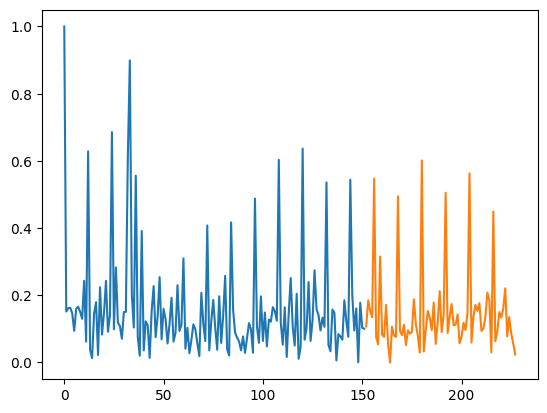

In [7]:
plt.plot(train)
plt.plot(np.arange(len(train),len(train)+len(test)),test)
plt.show()

In [9]:
lookback = 32
X_train, y_train = create_dataset(train, lookback=lookback)
X_test, y_test = create_dataset(test, lookback=lookback)
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

torch.Size([120, 32, 1]) torch.Size([120, 32, 1])
torch.Size([44, 32, 1]) torch.Size([44, 32, 1])


In [10]:
lstm = LSTM(input_size=32,hidden_size=256)
optimizer = optim.Adam(lstm.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train,y_train),shuffle=True,batch_size=8)

In [11]:
n_epochs = 2000
for epoch in range(n_epochs):
    lstm.train()
    for X_batch, y_batch in loader:
        y_pred = lstm(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    lstm.eval()
    with torch.no_grad():
        y_pred = lstm(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = lstm(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))
    

Epoch 0: train RMSE 0.1519, test RMSE 0.1257
Epoch 100: train RMSE 0.1517, test RMSE 0.1258
Epoch 200: train RMSE 0.1517, test RMSE 0.1259
Epoch 300: train RMSE 0.0403, test RMSE 0.1443
Epoch 400: train RMSE 0.0363, test RMSE 0.1683
Epoch 500: train RMSE 0.0363, test RMSE 0.1447
Epoch 600: train RMSE 0.0306, test RMSE 0.1662
Epoch 700: train RMSE 0.0299, test RMSE 0.1626
Epoch 800: train RMSE 0.0290, test RMSE 0.1580
Epoch 900: train RMSE 0.0281, test RMSE 0.1594
Epoch 1000: train RMSE 0.0264, test RMSE 0.1621
Epoch 1100: train RMSE 0.0308, test RMSE 0.1628
Epoch 1200: train RMSE 0.0271, test RMSE 0.1720
Epoch 1300: train RMSE 0.0263, test RMSE 0.1702
Epoch 1400: train RMSE 0.0316, test RMSE 0.1689
Epoch 1500: train RMSE 0.0276, test RMSE 0.1725
Epoch 1600: train RMSE 0.0280, test RMSE 0.1722
Epoch 1700: train RMSE 0.0275, test RMSE 0.1719
Epoch 1800: train RMSE 0.0310, test RMSE 0.1773
Epoch 1900: train RMSE 0.0274, test RMSE 0.1691


In [20]:
train_plot[lookback:train_size]

array([[0.75525004],
       [0.8764021 ],
       [0.18517992],
       [0.10147245],
       [0.6633896 ],
       [0.076281  ],
       [0.03088111],
       [0.38676313],
       [0.05738732],
       [0.12306973],
       [0.12449252],
       [0.03991728],
       [0.15123408],
       [0.21034665],
       [0.08592143],
       [0.13798326],
       [0.21580984],
       [0.08955662],
       [0.15368077],
       [0.12935081],
       [0.05054273],
       [0.11859614],
       [0.20005284],
       [0.07931178],
       [0.06713086],
       [0.20234883],
       [0.08585112],
       [0.11179674],
       [0.28580782],
       [0.05803805],
       [0.09146658],
       [0.03066868],
       [0.0880295 ],
       [0.1284693 ],
       [0.0947912 ],
       [0.04431486],
       [0.03002977],
       [0.19990191],
       [0.11267591],
       [0.04976895],
       [0.39494926],
       [0.03631711],
       [0.12240042],
       [0.17437255],
       [0.11177175],
       [0.0520885 ],
       [0.18852738],
       [0.056

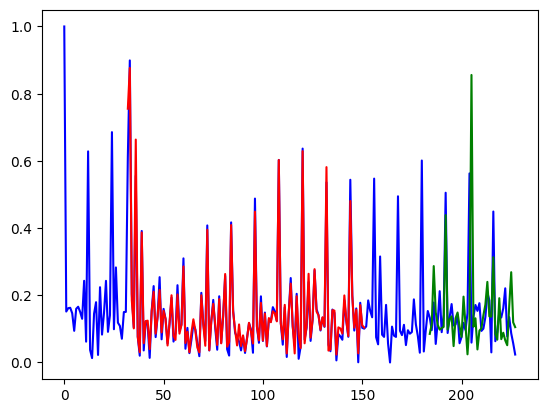

In [17]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    # y_pred = lstm(X_train)
    # y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = lstm(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = lstm(X_test)[:, -1, :]
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

In [ ]:
transformer = Transformer(feature_size=250, num_layers=2, dropout=0.5)
optimizer = optim.AdamW(transformer.parameters())
loss_fn = nn.MSELoss()
loader = data.DataLoader(data.TensorDataset(X_train,y_train),shuffle=True,batch_size=8)

In [ ]:
n_epochs = 4000
for epoch in range(n_epochs):
    transformer.train()
    for X_batch, y_batch in loader:
        y_pred = transformer(X_batch)
        loss = loss_fn(y_pred, y_batch)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # Validation
    if epoch % 100 != 0:
        continue
    transformer.eval()
    with torch.no_grad():
        y_pred = transformer(X_train)
        train_rmse = np.sqrt(loss_fn(y_pred, y_train))
        y_pred = transformer(X_test)
        test_rmse = np.sqrt(loss_fn(y_pred, y_test))
    print("Epoch %d: train RMSE %.4f, test RMSE %.4f" % (epoch, train_rmse, test_rmse))


In [ ]:
with torch.no_grad():
    # shift train predictions for plotting
    train_plot = np.ones_like(timeseries) * np.nan
    y_pred = transformer(X_train)
    y_pred = y_pred[:, -1, :]
    train_plot[lookback:train_size] = transformer(X_train)[:, -1, :]
    # shift test predictions for plotting
    test_plot = np.ones_like(timeseries) * np.nan
    test_plot[train_size+lookback:len(timeseries)] = transformer(X_test)[:, -1, :]
# plot
plt.plot(timeseries, c='b')
plt.plot(train_plot, c='r')
plt.plot(test_plot, c='g')
plt.show()

In [ ]:
y_pred = transformer(X_train)
y_pred[:,-1,:]

In [34]:
def is_palindrome_long_enough(text):
    """
    檢查一個字串是否為回文，且其長度是否大於 3。

    Args:
        text (str): 待檢查的字串。

    Returns:
        bool: 如果字串是回文且長度大於 3，則返回 True；
              否則返回 False。
    """
    # 步驟 1: 清理字串，只保留字母和數字，並轉換為小寫。
    # 這樣可以忽略大小寫和非字母數字字符的影響。
    cleaned_text = ''.join(char.lower() for char in text if char.isalnum())
    print(cleaned_text)
    # 步驟 2: 檢查清理後的字串長度是否大於 3。
    if len(cleaned_text) <= 3:
        return False

    # 步驟 3: 檢查清理後的字串是否為回文。
    # 將字串反轉與原字串比較。
    return cleaned_text == cleaned_text[::-1]

is_palindrome_long_enough("iooi")

iooi


True

In [23]:
def getMaxSubstrings(s, k):
    n = len(s)
    
    # 步驟1：使用DP識別所有回文子串
    dp = [[False] * n for _ in range(n)]
    
    # 每個字元都是回文
    for i in range(n):
        dp[i][i] = True
    
    # 檢查長度為2的回文
    for i in range(n - 1):
        if s[i] == s[i + 1]:
            dp[i][i + 1] = True
    
    # 檢查長度大於2的回文
    for length in range(3, n + 1):
        for i in range(n - length + 1):
            j = i + length - 1
            if s[i] == s[j] and dp[i + 1][j - 1]:
                dp[i][j] = True
    
    # 步驟2：按長度過濾子字串
    palindromic_substrings = []
    for i in range(n):
        for j in range(i + k - 1, n):
            if dp[i][j]:
                palindromic_substrings.append((i, j))
    
    # 步驟3：選擇非重疊回文子串
    palindromic_substrings.sort(key=lambda x: x[1])  # Sort by the end index
    max_count = 0
    last_end = -1
    
    for start, end in palindromic_substrings:
        if start > last_end:
            max_count += 1
            last_end = end
    
    return max_count
 
# 示例用法
s = "aababaabce"
k = 3
print(getMaxSubstrings(s, k))  # Output: 2


2
